# 📌 Project Title: Machine Learning Job Postings in the US — Predicting Seniority Level

## 🔍 Project Description
In this machine learning project, the objective is to predict the seniority level (e.g., "Entry level", "Mid-Senior", "Executive") of job postings using job descriptions and metadata. The dataset is sourced from Kaggle and contains ~988 records of job postings across companies in the US.

The project compares two distinct NLP approaches:

- TF-IDF-based text encoding

- LLM embeddings using SentenceTransformers

The pipeline also incorporates structured features such as job location, company, and days since the job was posted. The final goal is to compare model performance using traditional and LLM-based encodings.



## 🧱 Notebook Structure & Sections

### ✅ 1. Importing Required Libraries 
- Start by importing essential libraries (pandas, numpy, seaborn, sklearn, xgboost, lightgbm, matplotlib, etc.).

In [162]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import skew
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

### ✅ 2. Data Loading and Inspection
- Loaded job posting dataset (1000_ml_jobs_us.csv)
- Dropped unnecessary columns like website URLs and original date strings
- Extracted days_since_posted from date and dropped the original date columns

In [110]:
df = pd.read_csv('1000_ml_jobs_us.csv')

In [111]:
df.head()

,Unnamed: 0,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...
1,1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer
2,2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer
3,3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training"
4,4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer


In [112]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   job_posted_date           997 non-null    object
 1   company_address_locality  950 non-null    object
 2   company_address_region    884 non-null    object
 3   company_name              997 non-null    object
 4   company_website           983 non-null    object
 5   company_description       985 non-null    object
 6   job_description_text      996 non-null    object
 7   seniority_level           988 non-null    object
 8   job_title                 997 non-null    object
dtypes: object(9)
memory usage: 70.2+ KB


In [114]:
df.describe()

,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
count,997,950,884,997,983,985,996,988,997
unique,116,178,87,488,478,480,795,7,450
top,2025-04-09,San Francisco,California,TikTok,https://www.tiktok.com/about?lang=en,TikTok is the world's leading destination for ...,Meta is embarking on the most transformative c...,Mid-Senior level,Machine Learning Engineer
freq,87,148,308,88,88,88,12,371,243


In [115]:
df.isnull().sum()

job_posted_date               0
company_address_locality     47
company_address_region      113
company_name                  0
company_website              14
company_description          12
job_description_text          1
seniority_level               9
job_title                     0
dtype: int64

In [116]:
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

In [117]:
df['days_since_posted'] = (pd.Timestamp.now() - df['job_posted_date']).dt.days

In [118]:
df.drop('job_posted_date', axis = 1, inplace = True)
df.drop('company_website', axis = 1, inplace = True)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   company_address_locality  950 non-null    object
 1   company_address_region    884 non-null    object
 2   company_name              997 non-null    object
 3   company_description       985 non-null    object
 4   job_description_text      996 non-null    object
 5   seniority_level           988 non-null    object
 6   job_title                 997 non-null    object
 7   days_since_posted         997 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 62.4+ KB


In [120]:
# Drop rows with missing target variable
df = df.dropna(subset=['seniority_level']).reset_index(drop=True)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   company_address_locality  942 non-null    object
 1   company_address_region    877 non-null    object
 2   company_name              988 non-null    object
 3   company_description       977 non-null    object
 4   job_description_text      988 non-null    object
 5   seniority_level           988 non-null    object
 6   job_title                 988 non-null    object
 7   days_since_posted         988 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 61.9+ KB


### ✅ 3. Missing Value Handling
- Identified columns with missing values
- Added missing indicators for categorical columns before encoding
- Combined all textual columns into a new full_text column

In [122]:
# Create missingness indicator columns so that the model know that it is an imputer values
df['company_address_locality_missing'] = df['company_address_locality'].isnull().astype(int)
df['company_address_region_missing'] = df['company_address_region'].isnull().astype(int)

In [123]:
# Fill missing values
df['company_address_locality'] = df['company_address_locality'].fillna('US')
df['company_address_region'] = df['company_address_region'].fillna('Remote')

In [124]:
# Missingness indicator
df['company_description_missing'] = df['company_description'].isnull().astype(int)
# Fill missing text with a neutral, informative placeholder
df['company_description'] = df['company_description'].fillna('No company description provided')

In [125]:
#Adding Common Job Description for 1 row
df['job_description_text']= df['job_description_text'].fillna(
    "This role involves various responsibilities aligned with the position's requirements. "
    "Candidates are expected to demonstrate relevant skills and experience. More details will "
    "be provided during the interview process."
)

In [126]:
#Combine Text Features there are multiple textual columns (job_description_text, company_description, job_title). Let's create a single full_text feature:
df['full_text'] = df['job_title'] + ' ' + df['job_description_text'] + ' ' + df['company_description']

In [127]:
df.drop(['job_title', 'job_description_text', 'company_description'], axis = 1, inplace =True)

In [128]:
df.head()

,company_address_locality,company_address_region,company_name,seniority_level,days_since_posted,company_address_locality_missing,company_address_region_missing,company_description_missing,full_text
0,Indianapolis,Indiana,Upper Hand,Internship,240,0,0,0,Internship - Machine Learning Engineer & Data ...
1,San Francisco,California,Ikigai,Mid-Senior level,106,0,0,0,Machine Learning Engineer Company DescriptionT...
2,San Jose,CA,Adobe,Entry level,80,0,0,0,Machine Learning Engineer Our CompanyChanging ...
3,Mountain View,California,Waymo,Entry level,98,0,0,0,"Machine Learning Engineer, Training Waymo is a..."
4,Boston,Massachusetts,HMH,Mid-Senior level,92,0,0,0,Machine Learning Engineer Job Title: Machine L...


### ✅ 4. Exploratory Data Analysis (EDA)
- Count plots for categorical columns 
- Box plots for numerical features to check outliers
- Visualized target class balance (classification: binary - maintenance required or not)

In [129]:
#Seprating Numerical and Categorical Columns
categorical_columns = ['company_address_locality', 'company_address_region', 'company_name']
numerical_columns = ['days_since_posted']
full_text_columns = ['full_text']
missing_indicators = ['company_address_locality_missing', 'company_address_region_missing', 'company_description_missing']
target = 'seniority_level'

In [130]:
print(df['seniority_level'].nunique())
print(df['seniority_level'].value_counts())

7
seniority_level
Mid-Senior level    371
Entry level         300
Not Applicable      209
Internship           70
Associate            32
Director              5
Executive             1
Name: count, dtype: int64


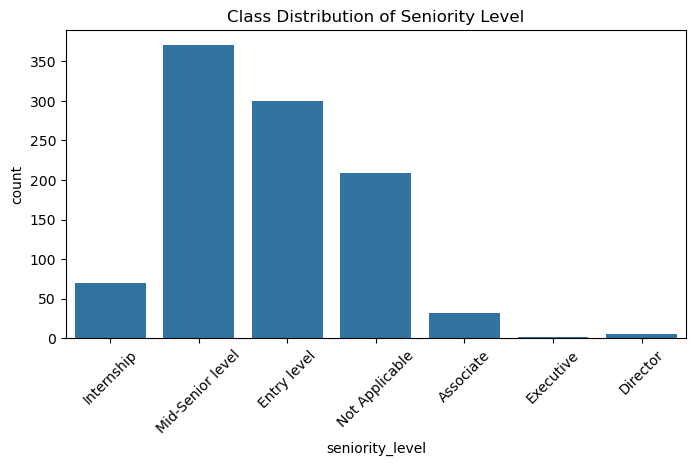

In [131]:
plt.figure(figsize=(8, 4))
sns.countplot(x='seniority_level', data=df)
plt.title('Class Distribution of Seniority Level')
plt.xticks(rotation=45)
plt.show()

In [132]:
class_counts = df['seniority_level'].value_counts(normalize=True) * 100
print(class_counts)

seniority_level
Mid-Senior level    37.550607
Entry level         30.364372
Not Applicable      21.153846
Internship           7.085020
Associate            3.238866
Director             0.506073
Executive            0.101215
Name: proportion, dtype: float64


In [133]:
def group_seniority(level):
    if level in ['Executive', 'Director']:
        return 'Senior/Executive'
    else:
        return level

df['seniority_level'] = df['seniority_level'].apply(group_seniority)

In [134]:
class_counts = df['seniority_level'].value_counts(normalize=True) * 100
print(class_counts)

seniority_level
Mid-Senior level    37.550607
Entry level         30.364372
Not Applicable      21.153846
Internship           7.085020
Associate            3.238866
Senior/Executive     0.607287
Name: proportion, dtype: float64


In [135]:
# class_weight_dict maps each class in 'seniority_level' to a weight inversely proportional 
# to its frequency. When passed to models like RandomForestClassifier or LogisticRegression, 
# it helps the model pay more attention to rare classes, improving performance on imbalanced data.
classes = df['seniority_level'].unique()
class_weights = compute_class_weight('balanced', classes=classes, y=df['seniority_level'])
class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)

{'Internship': np.float64(2.3523809523809525), 'Mid-Senior level': np.float64(0.44384546271338726), 'Entry level': np.float64(0.5488888888888889), 'Not Applicable': np.float64(0.7878787878787878), 'Associate': np.float64(5.145833333333333), 'Senior/Executive': np.float64(27.444444444444443)}


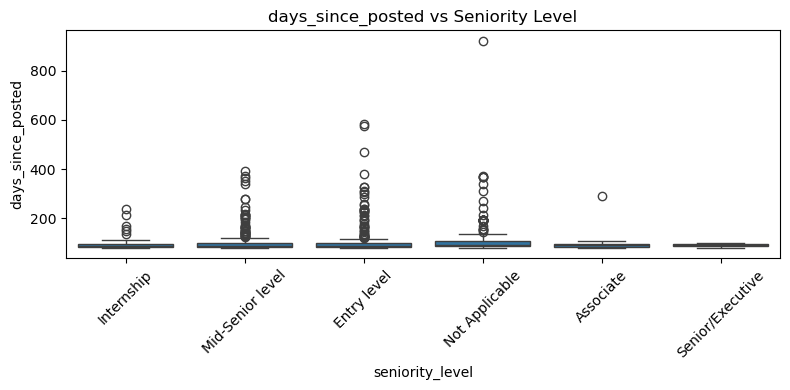

In [136]:
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=target, y=col, data=df)
    plt.title(f'{col} vs Seniority Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print('\n')

<Axes: xlabel='days_since_posted', ylabel='Count'>

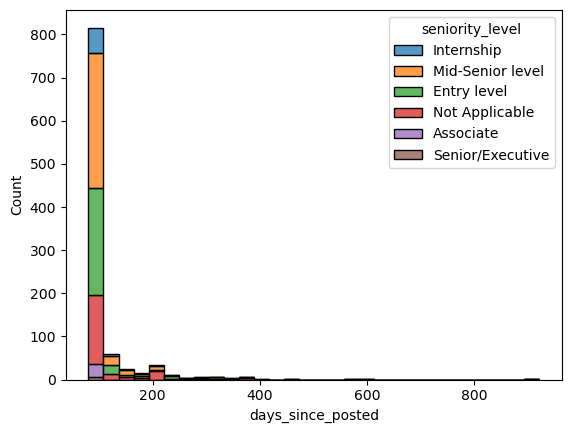

In [137]:
sns.histplot(data=df, x=col, hue=target, multiple="stack", bins=30)

In [138]:
for col in numerical_columns:
  print(f'{col} Skewness ', skew(df[col]))

days_since_posted Skewness  5.8444571365246185


In [139]:
df['days_since_posted'] = np.log1p(df['days_since_posted'])

In [140]:
print("Skewness after log:", skew(df['days_since_posted']))

Skewness after log: 2.8054505778816496


<Axes: xlabel='days_since_posted', ylabel='Count'>

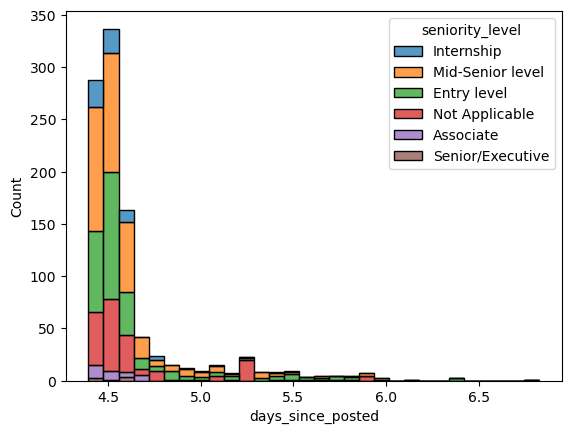

In [141]:
sns.histplot(data=df, x=col, hue=target, multiple="stack", bins=30)

In [142]:
df['days_since_posted'], _ = boxcox(df['days_since_posted'] + 1)
#df['days_since_posted'] = np.sqrt(df['days_since_posted'])

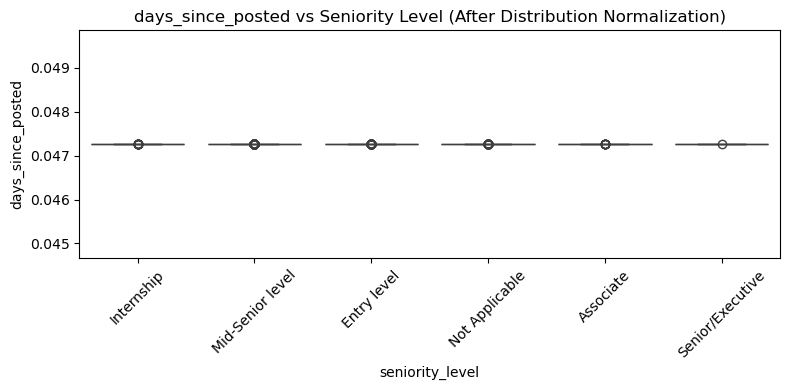

In [143]:
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=target, y=col, data=df)
    plt.title(f'{col} vs Seniority Level (After Distribution Normalization)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print('\n')

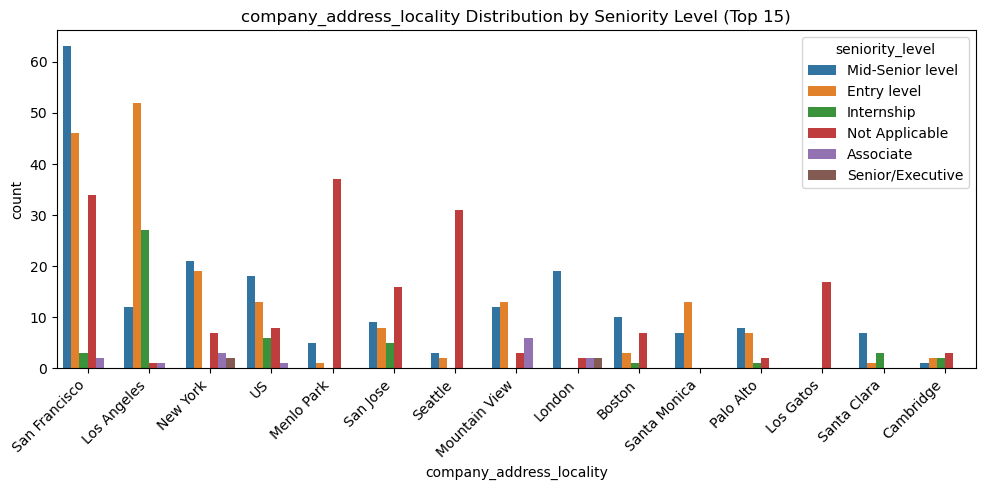

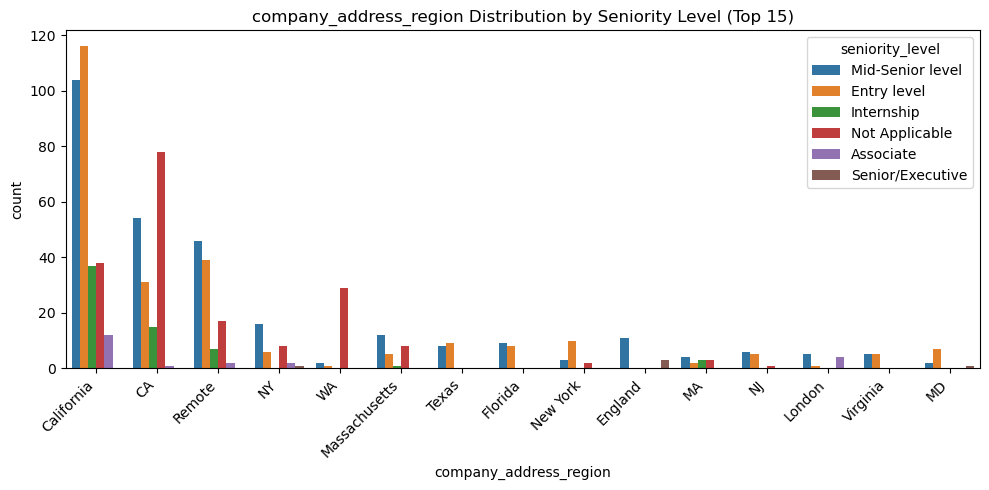

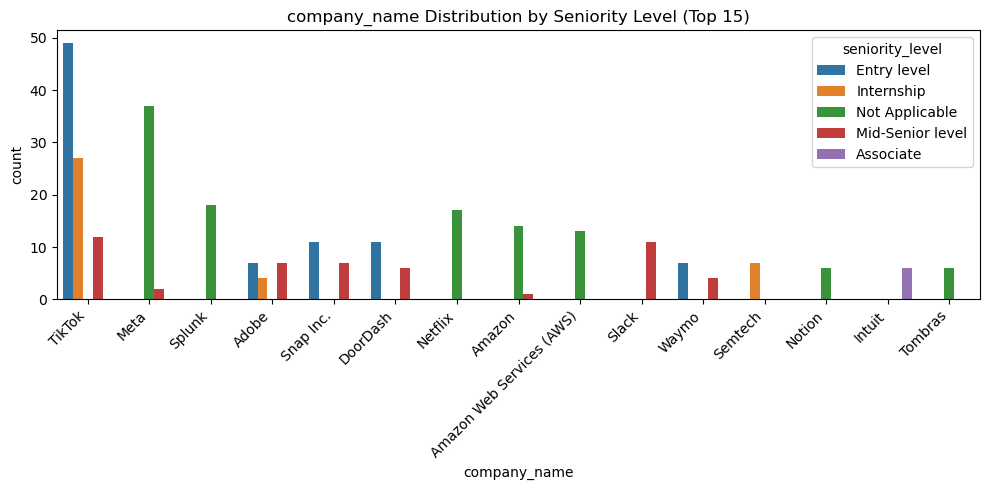

In [144]:
# Show only top 15 categories
top_n = 15

for col in categorical_columns:
    top_categories = df[col].value_counts().nlargest(top_n).index
    filtered_df = df[df[col].isin(top_categories)]
    
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue=target, data=filtered_df, order=top_categories)
    plt.title(f'{col} Distribution by Seniority Level (Top {top_n})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print('\n')

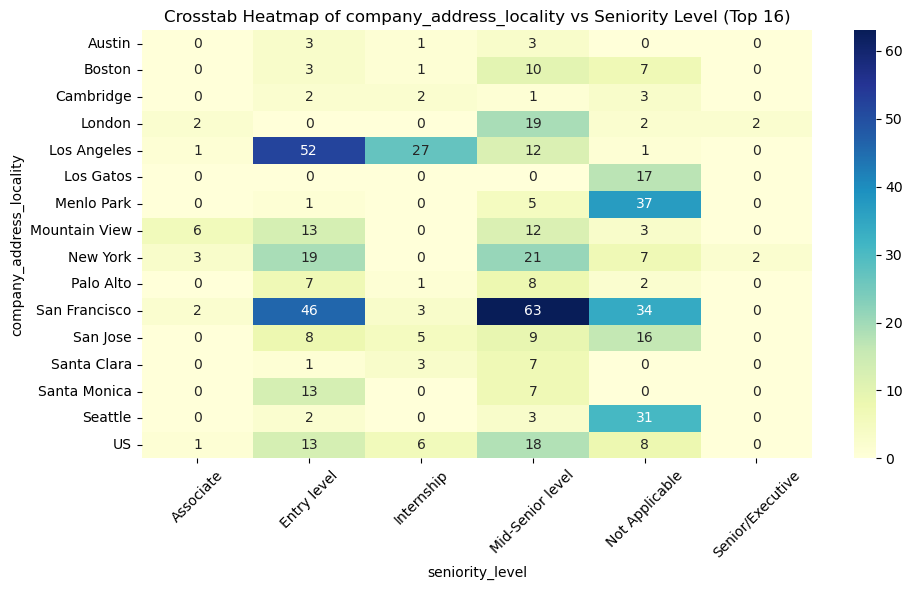

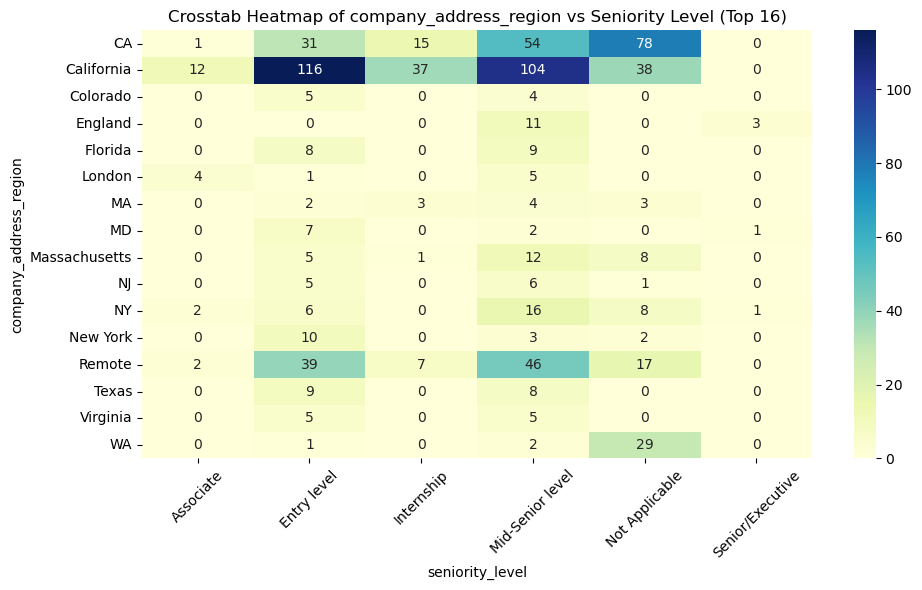

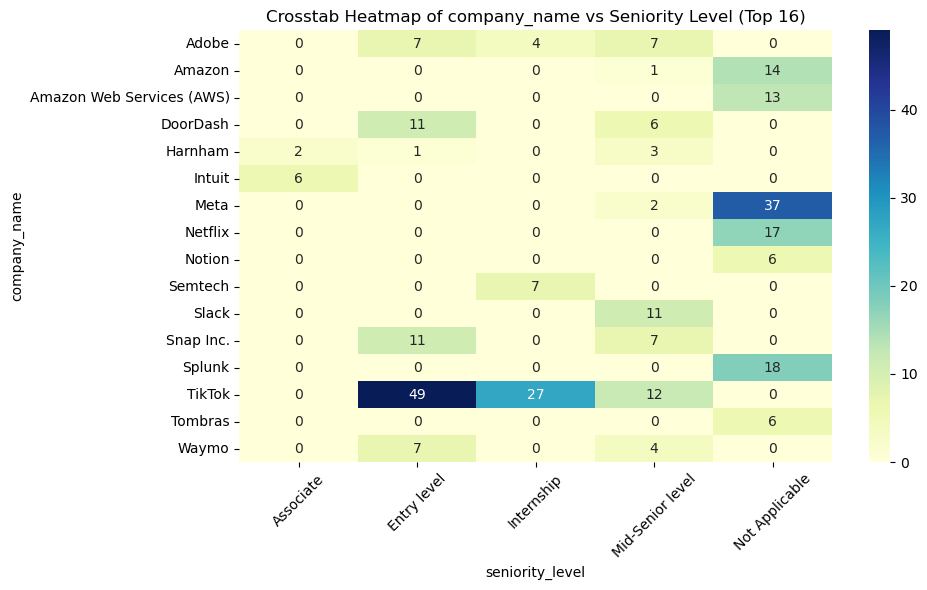

In [145]:
# Show only top 15 categories
top_n = 16  # or whatever number looks good

for col in categorical_columns:
    top_categories = df[col].value_counts().nlargest(top_n).index
    filtered_df = df[df[col].isin(top_categories)]
    
    ct = pd.crosstab(filtered_df[col], filtered_df[target])
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f'Crosstab Heatmap of {col} vs Seniority Level (Top {top_n})')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    print('\n')

In [147]:
for col in categorical_columns:
    print(f"Frequency of categories in {col}:")
    print(df[col].value_counts(normalize=True) * 100)  # Get percentage distribution
    print('\n')

Frequency of categories in company_address_locality:
company_address_locality
San Francisco    14.979757
Los Angeles       9.412955
New York          5.263158
US                4.655870
Menlo Park        4.352227
                   ...    
Brentwood         0.101215
Columbia          0.101215
Odessa            0.101215
Dallas            0.101215
Rothschild        0.101215
Name: proportion, Length: 179, dtype: float64


Frequency of categories in company_address_region:
company_address_region
California    31.072874
CA            18.117409
Remote        11.234818
NY             3.340081
WA             3.238866
                ...    
Chile          0.101215
Hawaii         0.101215
北京             0.101215
AL             0.101215
OH             0.101215
Name: proportion, Length: 88, dtype: float64


Frequency of categories in company_name:
company_name
TikTok                8.906883
Meta                  3.947368
Splunk                1.821862
Adobe                 1.821862
Snap Inc.     

### ✅ 5. Train-Test Split

In [148]:
X = df.drop('seniority_level', axis = 1)
y = df['seniority_level']

In [149]:
# Splitting the Data for TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.2, random_state=42)

### ✅ 6. Feature Engineering
- Used TF-IDF to transform full_text (For TF-IDF)
- Used SentenceTransformer for full_text (For LLM)
- Handled categorical variables using OneHotEncoder via ColumnTransformer

In [150]:
le = LabelEncoder()

In [151]:
# Fit and transform on training data, and transform on test data for TF-IDF
y_train_tfidf = le.fit_transform(y_train_tfidf)
y_test_tfidf = le.transform(y_test_tfidf)

### ✅ 7. Modeling: TF-IDF Based Pipeline
- Encoded categorical + numeric + text features into one combined matrix

In [152]:
# Define the columns for the transformers
categorical_columns = ['company_address_locality', 'company_address_region', 'company_name']
full_text_columns = ['full_text']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english'), 'full_text')  # Keep as string here
    ],
    remainder='passthrough'
)

# ✅ Make sure 'full_text' column exists in both train/test and is of string type
X_train_tfidf['full_text'] = X_train_tfidf['full_text'].astype(str)
X_test_tfidf['full_text'] = X_test_tfidf['full_text'].astype(str)

# Fit-transform on train, transform on test
X_train_tfidf = preprocessor.fit_transform(X_train_tfidf)
X_test_tfidf = preprocessor.transform(X_test_tfidf)

In [153]:
# Splitting the Data for LLM
X_train_llm, X_test_llm, y_train_llm, y_test_llm = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
le = LabelEncoder()

In [155]:
# Fit and transform on training data, and transform on test data for LLM
y_train_llm = le.fit_transform(y_train_llm)
y_test_llm = le.transform(y_test_llm)

### ✅ 8. LLM Embeddings with SentenceTransformer (BERT)
- Used sentence-transformers to convert full_text into dense vectors
- Replaced TF-IDF vector with LLM embeddings

In [156]:
# ✅ SBERT Embeddings
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embed = sbert_model.encode(X_train_llm['full_text'].astype(str).tolist(), show_progress_bar=True)
X_test_embed = sbert_model.encode(X_test_llm['full_text'].astype(str).tolist(), show_progress_bar=True)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [157]:
# ✅ Drop full_text after embedding
X_train_llm = X_train_llm.drop(columns=['full_text'])
X_test_llm = X_test_llm.drop(columns=['full_text'])

In [158]:
# ✅ OneHot Encode categorical features only
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train_llm[categorical_columns])
X_test_cat = ohe.transform(X_test_llm[categorical_columns])

In [159]:
# ✅ Concatenate everything (OneHot + Flags + SBERT Embeddings)
X_train_llm = np.hstack([
    X_train_cat,
    X_train_llm[numerical_columns + missing_indicators].values,
    X_train_embed
])

X_test_llm = np.hstack([
    X_test_cat,
    X_test_llm[numerical_columns + missing_indicators].values,
    X_test_embed
])

### ✅ 8. Modeling: TF-IDF and LLM Based Pipeline
- Encoded categorical + numeric + text features into one combined matrix
#### 8.1 Trained models:
- Logistic Regression
- Random Forest
- Support Vector Classifier
- XGBoost
- LightGBM

#### 8.2 Model Evaluation was done using:¶
- Accuracy
- Classification Report (Precision, Recall, F1-score)

##### Performed:
- Model training
- Accuracy calculation

In [163]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # 1. Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 2. Evaluation
    print(f"\n🔍 {model_name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # 3. Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("CV Accuracy Scores:", scores)
    print("Mean CV Accuracy:", scores.mean())
    return scores.mean()

In [164]:
lr = LogisticRegression(max_iter=1000)
svm = SVC()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

In [165]:
print("==== TF-IDF INPUT ====")
train_and_evaluate(lr, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, "Logistic Regression (TF-IDF)")
train_and_evaluate(svm, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, "SVM (TF-IDF)")
# rf, xgb, lgbm will require: .toarray()
train_and_evaluate(rf, X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train_tfidf, y_test_tfidf, "Random Forest (TF-IDF)")
train_and_evaluate(xgb, X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train_tfidf, y_test_tfidf, "XGBoost (TF-IDF)")
train_and_evaluate(lgbm, X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train_tfidf, y_test_tfidf, "LightGBM (TF-IDF)")

==== TF-IDF INPUT ====

🔍 Logistic Regression (TF-IDF) Evaluation:
Accuracy: 0.6363636363636364

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.52      0.63      0.57        54
           2       1.00      0.40      0.57        20
           3       0.56      0.68      0.61        71
           4       0.92      0.80      0.85        44
           5       0.00      0.00      0.00         1

    accuracy                           0.64       198
   macro avg       0.67      0.44      0.47       198
weighted avg       0.69      0.64      0.63       198



/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CV Accuracy Scores: [0.60759494 0.66455696 0.60126582 0.67721519 0.66455696]
Mean CV Accuracy: 0.6430379746835444

🔍 SVM (TF-IDF) Evaluation:
Accuracy: 0.6313131313131313

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.57      0.56      0.56        54
           2       1.00      0.30      0.46        20
           3       0.52      0.76      0.62        71
           4       0.97      0.77      0.86        44
           5       0.00      0.00      0.00         1

    accuracy                           0.63       198
   macro avg       0.68      0.42      0.45       198
weighted avg       0.70      0.63      0.62       198



/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CV Accuracy Scores: [0.57594937 0.63924051 0.59493671 0.62025316 0.62025316]
Mean CV Accuracy: 0.6101265822784809

🔍 Random Forest (TF-IDF) Evaluation:
Accuracy: 0.6414141414141414

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.52      0.61      0.56        54
           2       1.00      0.45      0.62        20
           3       0.57      0.73      0.64        71
           4       1.00      0.70      0.83        44
           5       1.00      1.00      1.00         1

    accuracy                           0.64       198
   macro avg       0.76      0.60      0.64       198
weighted avg       0.69      0.64      0.64       198

CV Accuracy Scores: [0.60126582 0.67088608 0.65189873 0.67721519 0.63924051]
Mean CV Accuracy: 0.6481012658227848

🔍 XGBoost (TF-IDF) Evaluation:
Accuracy: 0.6414141414141414

Classification Report:
               precision    recall  f1-score   suppo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67378
[LightGBM] [Info] Number of data points in the train set: 790, number of used features: 2172
[LightGBM] [Info] Start training from score -3.493979
[LightGBM] [Info] Start training from score -1.166701
[LightGBM] [Info] Start training from score -2.760010
[LightGBM] [Info] Start training from score -0.968250
[LightGBM] [Info] Start training from score -1.566087
[LightGBM] [Info] Start training from score -5.062595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52417
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 1892
[LightGBM] [Info] Start training from score -3.453157
[LightGBM] [Info] Start training from score -1.170775
[LightGBM] [Info] Start training from score -2.760010
[LightGBM] [Info] Start training from score -0.968250
[LightGBM] [Info] Start training from score -1.566087
[LightGBM] [Info] Start training from score -5.062595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53544
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 1912
[LightGBM] [Info] Start training from score -3.504450
[LightGBM] [Info] Start training from score -1.165686
[LightGBM] [Info] Start training from score -2.760010
[LightGBM] [Info] Start training from score -0.968250
[LightGBM] [Info] Start training from score -1.566087
[LightGBM] [Info] Start training from score -5.062595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52690
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 1861
[LightGBM] [Info] Start training from score -3.504450
[LightGBM] [Info] Start training from score -1.165686
[LightGBM] [Info] Start training from score -2.760010
[LightGBM] [Info] Start training from score -0.968250
[LightGBM] [Info] Start training from score -1.566087
[LightGBM] [Info] Start training from score -5.062595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


np.float64(0.6670886075949367)

In [166]:
print("\n==== SBERT INPUT ====")
train_and_evaluate(lr, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "Logistic Regression (SBERT)")
train_and_evaluate(svm, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "SVM (SBERT)")
train_and_evaluate(rf, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "Random Forest (SBERT)")
train_and_evaluate(xgb, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "XGBoost (SBERT)")
train_and_evaluate(lgbm, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "LightGBM (SBERT)")


==== SBERT INPUT ====

🔍 Logistic Regression (SBERT) Evaluation:
Accuracy: 0.6161616161616161

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.52      0.63      0.57        54
           2       1.00      0.30      0.46        20
           3       0.54      0.65      0.59        71
           4       0.88      0.80      0.83        44
           5       0.00      0.00      0.00         1

    accuracy                           0.62       198
   macro avg       0.66      0.42      0.45       198
weighted avg       0.67      0.62      0.61       198



/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CV Accuracy Scores: [0.59493671 0.63924051 0.58860759 0.65822785 0.62025316]
Mean CV Accuracy: 0.620253164556962

🔍 SVM (SBERT) Evaluation:
Accuracy: 0.6161616161616161

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.54      0.56      0.55        54
           2       1.00      0.15      0.26        20
           3       0.53      0.77      0.63        71
           4       0.94      0.75      0.84        44
           5       0.00      0.00      0.00         1

    accuracy                           0.62       198
   macro avg       0.67      0.39      0.42       198
weighted avg       0.69      0.62      0.60       198



/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CV Accuracy Scores: [0.57594937 0.63291139 0.56962025 0.61392405 0.63291139]
Mean CV Accuracy: 0.6050632911392405

🔍 Random Forest (SBERT) Evaluation:
Accuracy: 0.5959595959595959

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.48      0.46      0.47        54
           2       0.86      0.30      0.44        20
           3       0.53      0.80      0.64        71
           4       1.00      0.64      0.78        44
           5       1.00      1.00      1.00         1

    accuracy                           0.60       198
   macro avg       0.73      0.55      0.59       198
weighted avg       0.65      0.60      0.59       198

CV Accuracy Scores: [0.59493671 0.60759494 0.59493671 0.61392405 0.60126582]
Mean CV Accuracy: 0.6025316455696202

🔍 XGBoost (SBERT) Evaluation:
Accuracy: 0.5808080808080808

Classification Report:
               precision    recall  f1-score   support

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


np.float64(0.6126582278481013)

### ✅ 9. Hyperparameter Tuning (Validation Step)
- Hyperparameter tuning with GridSearchCV for Logistic Regression, SVM, Random Forest, XGBoost, SVM, and LightGBM
- Tuned parameters like C, penalty, max_depth, n_estimators, learning_rate, etc.
- Results stayed consistent — confirming models are already generalizing well.
- Cross-validation
- Re-trained models using the same pipeline
- Compared accuracy & performance with TF-IDF version

In [169]:
# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Support Vector Machine
param_grid_svmc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_svmc = GridSearchCV(SVC(), param_grid_svmc, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Random Forest
param_grid_rfc = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid_rfc, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# XGBoost
param_grid_xgbc = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
grid_xgbc = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgbc, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# LightGBM
param_grid_lgbmc = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20]
}
grid_lgbmc = GridSearchCV(LGBMClassifier(), param_grid_lgbmc, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

In [173]:
def hyperparameter_tuning_validation(param_grid, X_train, X_test, y_train, y_test, model_name="Model"):
    # 1. Train
    param_grid.fit(X_train, y_train)
    y_pred = param_grid.predict(X_test)

    # 2. Evaluation
    print(f"\n🔍 {model_name} Evaluation:")
    print(f"🔧 Best Parameters for {model_name}:", param_grid.best_params_)
    print("✅ Best CV Accuracy:", param_grid.best_score_)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # 3. Cross-validation
    scores = cross_val_score(param_grid, X_train, y_train, cv=5)
    print("CV Accuracy Scores:", scores)
    print("Mean CV Accuracy:", scores.mean())
    return scores.mean()

In [176]:
print("==== TF-IDF INPUT (HyperParameter Tuned) ====")
hyperparameter_tuning_validation(grid_lr, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, "Logistic Regression (TF-IDF)")
#hyperparameter_tuning_validation(grid_svmc, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, "SVM (TF-IDF)")
# rf, xgb, lgbm will require: .toarray()
#hyperparameter_tuning_validation(grid_rfc, X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train_tfidf, y_test_tfidf, "Random Forest (TF-IDF)")
#hyperparameter_tuning_validation(grid_xgbc, X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train_tfidf, y_test_tfidf, "XGBoost (TF-IDF)")
#hyperparameter_tuning_validation(grid_lgbmc, X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train_tfidf, y_test_tfidf, "LightGBM (TF-IDF)")

==== TF-IDF INPUT (HyperParameter Tuned) ====
Fitting 3 folds for each of 4 candidates, totalling 12 fits

🔍 Logistic Regression (TF-IDF) Evaluation:
🔧 Best Parameters for Logistic Regression (TF-IDF): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
✅ Best CV Accuracy: 0.632902216077121
Accuracy: 0.6414141414141414

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.51      0.63      0.56        54
           2       0.89      0.40      0.55        20
           3       0.59      0.66      0.62        71
           4       0.90      0.82      0.86        44
           5       1.00      1.00      1.00         1

    accuracy                           0.64       198
   macro avg       0.81      0.61      0.64       198
weighted avg       0.68      0.64      0.64       198

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 1

np.float64(0.6518987341772152)

In [175]:
print("\n==== SBERT INPUT (HyperParameter Tuned) ====")
hyperparameter_tuning_validation(grid_lr, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "Logistic Regression (SBERT)")
#hyperparameter_tuning_validation(grid_svmc, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "SVM (SBERT)")
#hyperparameter_tuning_validation(grid_rfc, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "Random Forest (SBERT)")
#hyperparameter_tuning_validation(grid_xgbc, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "XGBoost (SBERT)")
#hyperparameter_tuning_validation(grid_lgbmc, X_train_llm, X_test_llm, y_train_llm, y_test_llm, "LightGBM (SBERT)")


==== SBERT INPUT (HyperParameter Tuned) ====
Fitting 3 folds for each of 4 candidates, totalling 12 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


🔍 Logistic Regression (SBERT) Evaluation:
🔧 Best Parameters for Logistic Regression (SBERT): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
✅ Best CV Accuracy: 0.6253024541997926
Accuracy: 0.6515151515151515

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.52      0.69      0.59        54
           2       1.00      0.40      0.57        20
           3       0.61      0.63      0.62        71
           4       0.86      0.84      0.85        44
           5       1.00      1.00      1.00         1

    accuracy                           0.65       198
   macro avg       0.83      0.61      0.64       198
weighted avg       0.70      0.65      0.64       198

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates

np.float64(0.6417721518987343)

### 10. 📊 Conclusion / Results
#### The best accuracy was achieved using XGBoost + TF-IDF, though overall model accuracy was low (~60–45%), which is expected given:

- Small dataset size (~988 rows)
- Class imbalance
- Missing values in multiple categorical features

#### The LLM-based model showed slightly improved results but was limited by low sample size.
- 🔁 A larger, cleaner dataset would significantly improve classification results.